# Prediction of forest fire in Portugal

Through a regression model, we will predict the damaged areas by forest fire on a  region of Portugal. The prediction consist on whether a forest fire can be affected by a fire, and if it is, how many hectareas can be the fire affect.


## 1. Data

The data is downloaded from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Forest+Fires
Data Set Information:

#### Prior results
In [Cortez and Morais, 2007], the output 'area' was first transformed with a ln(x+1) function. Then, several Data Mining methods were applied. After fitting the models, the outputs were post-processed with the inverse of the ln(x+1) transform. Four different input setups were used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value: 12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The best RMSE was attained by the naive mean predictor. An analysis to the regression error curve (REC) shows that the SVM model predicts more examples within a lower admitted error. In effect, the SVM model predicts better small fires, which are the majority. 

### Features

1. `X `- x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. `Y `- y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. `month` - month of the year: 'jan' to 'dec'
4. `day` - day of the week: 'mon' to 'sun'
5. `FFMC` - FFMC (Fine Fuel Moisture Code) index from the FWI system: 18.7 to 96.20
6. `DMC` - DMC (Dufe moisture Code) index from the FWI system: 1.1 to 291.3
7. `DC` - DC (Drought Code) index from the FWI (Fire Weather Index) system: 7.9 to 860.6
8. `ISI` - ISI (Initial Spread Index) index from the FWI system: 0.0 to 56.10
9. `temp` - temperature in Celsius degrees: 2.2 to 33.30
10. `RH` - relative humidity in %: 15.0 to 100
11. `wind` - wind speed in km/h: 0.40 to 9.40
12. `rain` - outside rain in mm/m2 : 0.0 to 6.4
13. `area` - the burned area of the forest (in ha): 0.00 to 1090.84 

`FFMC`: Denotes the moisture content surface litter and influences ignition and fire spread. 

`DMC and DC`: Represent the moisture content of shallow and deep organic layers, which affect fire intensity.

`ISI`: Score that correlates with fire velocity spread.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Transforming categorical data month into numbers
def cat_trans(X):
    X['month'] = X['month'].replace('jan', 1)
    X['month'] = X['month'].replace('feb', 2)
    X['month'] = X['month'].replace('mar', 3)
    X['month'] = X['month'].replace('apr', 4)
    X['month'] = X['month'].replace('may', 5)
    X['month'] = X['month'].replace('jun', 6)
    X['month'] = X['month'].replace('jul', 7)
    X['month'] = X['month'].replace('aug', 8)
    X['month'] = X['month'].replace('sep', 9)
    X['month'] = X['month'].replace('oct', 10)
    X['month'] = X['month'].replace('nov', 11)
    X['month'] = X['month'].replace('dec', 12)
#     X['day'] = X['day'].replace('sun', 1)
#     X['day'] = X['day'].replace('mon', 2)
#     X['day'] = X['day'].replace('tue', 3)
#     X['day'] = X['day'].replace('wed', 4)
#     X['day'] = X['day'].replace('thu', 5)
#     X['day'] = X['day'].replace('fri', 6)
#     X['day'] = X['day'].replace('sat', 7)
    
    return X

In [8]:
def model_test(model, data):
    np.random.seed(42)
                  
    data.drop(['ISI', 'wind', 'rain', 'day', 'X', 'Y'], axis=1, inplace=True)
    
    
    X = data.drop('area', axis=1)
    y = data['area']
    
    X = cat_trans(X)
    
    #Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train = np.array(y_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.fit_transform(y_test)
    
    # Fitting the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Making predictions
    pred = model.predict(X_test_scaled)
    
    pred_u = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
    y_test_u = scaler.inverse_transform(np.array(y_test_scaled).reshape(-1, 1))
    diff = np.array(pred_u) - np.array(y_test_u)
    
    summary_diff = pd.DataFrame(np.concatenate((pred_u, y_test_u, diff), axis=1), columns=["Predictions", "Real", "Difference"])
    
    
    return r2_score(y_test_scaled, pred_u), mean_absolute_error(y_test_scaled, pred_u), mean_squared_error(y_test_scaled, pred_u)


### Using the original dataset

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
model_orig = GradientBoostingRegressor()
data = pd.read_csv('datasets/forestfires.csv')
r2_score_orig, mean_absolute_error_orig, mean_squared_error_orig = model_test(model_orig, data)
r2_score_orig, mean_absolute_error_orig, mean_squared_error_orig

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-1178158.2697205255, 28.88499022466679, 9380.45662813808)

### Tuning the model by hyperparameter

In [7]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)
data = pd.read_csv('datasets/forestfires.csv')
#data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop(['ISI', 'wind', 'rain', 'day', 'X', 'Y'], axis=1, inplace=True)

X = data.drop('area', axis=1)
y = data['area']

X = cat_trans(X)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scaling the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)


# Different Support Vector Regressor hyperparameter
rf_grid = {"loss":['ls', 'lad', 'huber', 'quantile'],
           "learning_rate": [0.1, 0.2, 0.3],
           "n_estimators": np.arange(0,100,10),
           "criterion":['friedman_mse', 'mse', 'mae'],
           "min_samples_split":[2,3,4,5,6,7,8],
           "min_samples_leaf":[1,2,3,4,5,6,7,8],
           "max_features":['auto', 'sqrt', 'log2']
           
    

          }  # limiting the maximum to save time

# Instantiate RandomizedSearchCV model
gd_model = RandomizedSearchCV(GradientBoostingRegressor(),
                              param_distributions=rf_grid,
                              n_iter = 100, 
                              cv=20,
                              verbose=True
                             )
# Fit the RandomizedSearchCV model
gd_model.fit(X_train_scaled, y_train_scaled)

#print(tree_model.best_params_)
gd.best_params_

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

NameError: name 'gd' is not defined

In [9]:
gd_model.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 7,
 'max_features': 'auto',
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'mae'}

In [11]:
model_orig_tuned = GradientBoostingRegressor(n_estimators=50, min_samples_split=3, min_samples_leaf=7,
                                 max_features='auto', loss='huber', learning_rate=0.1, criterion='friedman_mse')
data = pd.read_csv('datasets/forestfires.csv')
r2_score_orig_tuned, mean_absolute_orig_tuned, mean_square_error_orig_tuned = model_test(model_orig_tuned, data)
r2_score_orig_tuned, mean_absolute_orig_tuned, mean_square_error_orig_tuned

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-11772.316039817613, 8.086418518975863, 93.73866786879253)

## Dataset with no outliers

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
model_orig_no = GradientBoostingRegressor()
data = pd.read_csv('datasets/forestfires_no_outliers.csv')
r2_score_orig_no, mean_absolute_error_orig_no, mean_squared_error_orig_no = model_test(model_orig, data)
r2_score_orig_no, mean_absolute_error_orig_no, mean_squared_error_orig_no

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-1779.6641733094375, 2.631789499582348, 32.13971993059359)

In [26]:
np.random.seed(42)
data = pd.read_csv('datasets/forestfires_no_outliers.csv')
#data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop(['ISI', 'wind', 'rain', 'day', 'X', 'Y'], axis=1, inplace=True)

X = data.drop('area', axis=1)
y = data['area']

X = cat_trans(X)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scaling the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)


# Different Support Vector Regressor hyperparameter
rf_grid = {"loss":['ls', 'lad', 'huber', 'quantile'],
           "learning_rate": [0.1, 0.2, 0.3],
           "n_estimators": np.arange(0,100,10),
           "criterion":['friedman_mse', 'mse', 'mae'],
           "min_samples_split":[2,3,4,5,6,7,8],
           "min_samples_leaf":[1,2,3,4,5,6,7,8],
           "max_features":['auto', 'sqrt', 'log2']
           
    

          }  # limiting the maximum to save time

# Instantiate RandomizedSearchCV model
gd_model = RandomizedSearchCV(GradientBoostingRegressor(),
                              param_distributions=rf_grid,
                              n_iter = 100, 
                              cv=20,
                              verbose=True
                             )
# Fit the RandomizedSearchCV model
gd_model.fit(X_train_scaled, y_train_scaled);

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

In [27]:
gd_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'mse'}

In [38]:
model_orig_no_tuned = GradientBoostingRegressor(n_estimators=100, min_samples_split=4,
                                               min_samples_leaf=6, max_features='auto', loss='lad',
                                               learning_rate=0.1, criterion='mae')
data = pd.read_csv('datasets/forestfires_no_outliers.csv')
r2_score_orig_no_tuned, mean_absolute_error_orig_no_tuned, mean_square_error_orig_no_tuned = model_test(model_orig_no_tuned, data)
r2_score_orig_no_tuned, mean_absolute_error_orig_no_tuned, mean_square_error_orig_no_tuned

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-257.1311276125699, 1.1516194469972707, 4.659082982175897)

## Dataset hazard with outlier


In [34]:
model_aff = GradientBoostingRegressor(n_estimators=50, min_samples_split=3, min_samples_leaf=2,
                                 max_features='auto', loss='huber', learning_rate=0.1, criterion='mse')
data = pd.read_csv('datasets/forest_fires_affected_areas.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
r2_score_aff, mean_absolute_error_aff, mean_square_error_aff = model_test(model_aff, data)
r2_score_aff, mean_absolute_error_aff, mean_square_error_aff

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-80994.14935483514, 21.966257468346885, 1194.839493077713)

### Result
The best result we have obtained so far

## Dataset hazard without outlier

In [42]:
model_aff_no = GradientBoostingRegressor(n_estimators=100, min_samples_split=3, min_samples_leaf=8,
                                 max_features='auto', loss='huber', learning_rate=0.1, criterion='friedman_mse')
data = pd.read_csv('datasets/forestfires_affected_areas_no_outliers.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
r2_score_aff_no, mean_absolute_error_aff_no, mean_square_error_aff_no = model_test(model_aff_no, data)
r2_score_aff_no, mean_absolute_error_aff_no, mean_square_error_aff_no

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-2138.790182288223, 8.06185021704249, 82.80764546085645)

### Results
Without outliers, the model does not do any better.

### Tuning the model

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)
data = pd.read_csv('datasets/forestfires_affected_areas_no_outliers.csv')
#data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop(['ISI', 'wind', 'rain', 'day', 'X', 'Y'], axis=1, inplace=True)

X = data.drop('area', axis=1)
y = data['area']

X = cat_trans(X)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scaling the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)

# Different Support Vector Regressor hyperparameter
rf_grid = {"loss":['ls', 'lad', 'huber', 'quantile'],
           "learning_rate": [0.1, 0.2, 0.3],
           "n_estimators": np.arange(0,100,10),
           "criterion":['friedman_mse', 'mse', 'mae'],
           "min_samples_split":[2,3,4,5,6,7,8],
           "min_samples_leaf":[1,2,3,4,5,6,7,8],
           "max_features":['auto', 'sqrt', 'log2']
           
    

          }  # limiting the maximum to save time

# Instantiate RandomizedSearchCV model
gd_model = RandomizedSearchCV(GradientBoostingRegressor(),
                              param_distributions=rf_grid,
                              n_iter = 100, 
                              cv=20,
                              verbose=True
                             )
# Fit the RandomizedSearchCV model
gd_model.fit(X_train_scaled, y_train_scaled)



Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater than 0 but was 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\model_selection\_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_estimators must be greater tha

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-pack

NameError: name 'gd' is not defined

In [18]:
gd_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'loss': 'lad',
 'learning_rate': 0.1,
 'criterion': 'mse'}

#### Trying the best model

In [44]:
model_aff_no_tuned = GradientBoostingRegressor(n_estimators=20, min_samples_split=7, min_samples_leaf=2,
                                 max_features='auto', loss='lad', learning_rate=0.1, criterion='mse')
data = pd.read_csv('datasets/forestfires_affected_areas_no_outliers.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

r2_score_aff_no_tuned, mean_absolute_error_aff_no_tuned, mean_square_error_aff_no_tuned = model_test(model_aff_no_tuned, data)
r2_score_aff_no_tuned, mean_absolute_error_aff_no_tuned, mean_square_error_aff_no_tuned

C:\Users\sandra\Desktop\Miniconda_projects\projects\forest_fires\env\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(-551.375453687499, 4.419561004833015, 21.376353209229265)

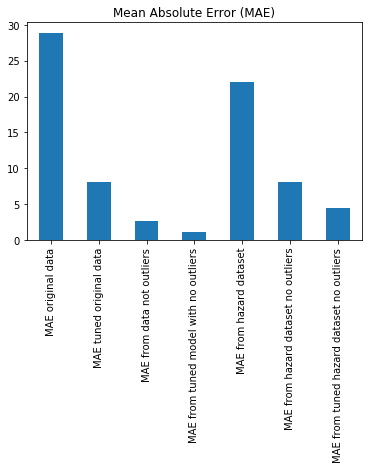

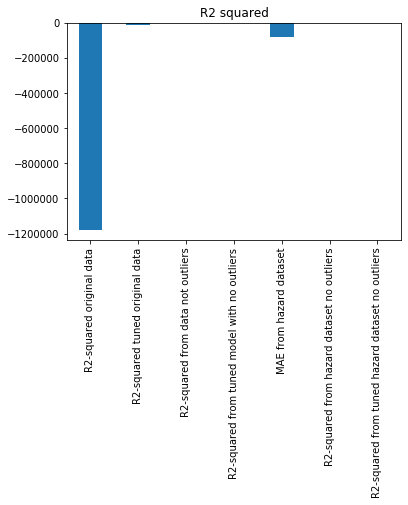

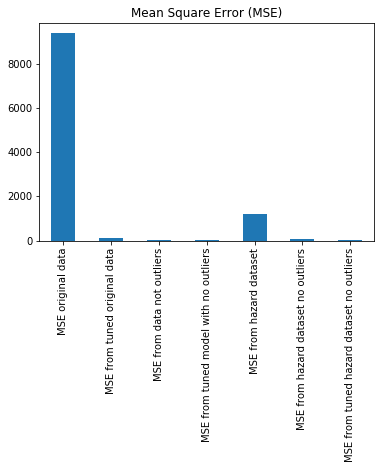

In [43]:
mae_sum = pd.DataFrame(data = [mean_absolute_error_orig, mean_absolute_orig_tuned, mean_absolute_error_orig_no, 
                    mean_absolute_error_orig_no_tuned, mean_absolute_error_aff, mean_absolute_error_aff_no, mean_absolute_error_aff_no_tuned], 
             index=["MAE original data","MAE tuned original data", "MAE from data not outliers", "MAE from tuned model with no outliers", "MAE from hazard dataset",
                   "MAE from hazard dataset no outliers", "MAE from tuned hazard dataset no outliers"])
r2_sum = pd.DataFrame(data = [r2_score_orig, r2_score_orig_tuned, r2_score_orig_no, r2_score_aff_no_tuned, r2_score_aff, r2_score_aff_no,
                              r2_score_aff_no_tuned], 
             index=["R2-squared original data","R2-squared tuned original data", "R2-squared from data not outliers", "R2-squared from tuned model with no outliers", "MAE from hazard dataset",
                   "R2-squared from hazard dataset no outliers", "R2-squared from tuned hazard dataset no outliers"])
mse_sum = pd.DataFrame(data = [mean_squared_error_orig, mean_square_error_orig_tuned,mean_squared_error_orig_no, mean_square_error_orig_no_tuned,
                    mean_square_error_aff, mean_square_error_aff_no, mean_square_error_aff_no_tuned], 
             index=["MSE original data","MSE from tuned original data","MSE from data not outliers", "MSE from tuned model with no outliers", "MSE from hazard dataset",
                   "MSE from hazard dataset no outliers", "MSE from tuned hazard dataset no outliers"])


ax1 = mae_sum.plot(kind='bar', legend=None, title='Mean Absolute Error (MAE)')


ax2 = r2_sum.plot(kind='bar', legend=None, title='R2 squared')


ax3 = mse_sum.plot(kind='bar', legend=None, title='Mean Square Error (MSE)')


plt.show()

## Summary of Results

Gradient Boosting is the best model for our problem. We could obtain a Mean Absolute Error from the original dataset without outliers of around 1.3ha. Among all the models tried for this project: Random Forest, Decision Tree Regressor and Support Vector Regressor. Gradient Boosting obtained the best results.